In [1]:
import numpy as np
import gym
from gym import spaces

class ElevatorEnv(gym.Env):
    def __init__(self, num_floors=10):
        super(ElevatorEnv, self).__init__()

        # Environment Parameters
        self.num_floors = num_floors
        self.current_floor = 0  # Start at ground floor
        self.destination_floor = np.random.randint(0, num_floors)  # Random request floor
        
        # Define Action Space (Move Up, Move Down, Open/Close Doors)
        self.action_space = spaces.Discrete(3)  # 0=Down, 1=Up, 2=Stop/Open

        # Define State Space (Current floor, Destination floor)
        self.observation_space = spaces.Box(low=0, high=num_floors-1, shape=(2,), dtype=np.int32)

    def step(self, action):
        reward = 0

        # Elevator Actions
        if action == 0 and self.current_floor > 0:
            self.current_floor -= 1  # Move Down
        elif action == 1 and self.current_floor < self.num_floors - 1:
            self.current_floor += 1  # Move Up
        elif action == 2:  # Open/Close Doors
            if self.current_floor == self.destination_floor:
                reward += 10  # Reward for reaching the correct floor
                self.destination_floor = np.random.randint(0, self.num_floors)  # New Request
        
        # Penalize unnecessary moves
        reward -= abs(self.current_floor - self.destination_floor)

        # Check if the episode is done (elevator serves the request)
        done = self.current_floor == self.destination_floor

        return np.array([self.current_floor, self.destination_floor]), reward, done, {}

    def reset(self):
        self.current_floor = 0
        self.destination_floor = np.random.randint(0, self.num_floors)
        return np.array([self.current_floor, self.destination_floor])

    def render(self):
        print(f"Elevator at Floor: {self.current_floor}, Destination: {self.destination_floor}")


In [2]:
import random

# Initialize Q-table
q_table = np.zeros((10, 10, 3))  # Floors x Floors x Actions

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration-exploitation trade-off

env = ElevatorEnv()

# Train for 10,000 episodes
for episode in range(10000):
    state = env.reset()
    done = False
    
    while not done:
        # Choose action (explore or exploit)
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[state[0], state[1]])  # Exploit best known action
        
        # Perform action
        new_state, reward, done, _ = env.step(action)
        
        # Update Q-table using Bellman equation
        q_table[state[0], state[1], action] = (1 - alpha) * q_table[state[0], state[1], action] + \
                                              alpha * (reward + gamma * np.max(q_table[new_state[0], new_state[1]]))
        
        state = new_state  # Move to the next state


In [3]:
state = env.reset()
done = False

while not done:
    action = np.argmax(q_table[state[0], state[1]])  # Select best action
    state, reward, done, _ = env.step(action)
    env.render()


Elevator at Floor: 1, Destination: 6
Elevator at Floor: 2, Destination: 6
Elevator at Floor: 3, Destination: 6
Elevator at Floor: 4, Destination: 6
Elevator at Floor: 5, Destination: 6
Elevator at Floor: 6, Destination: 6


In [4]:
total_reward = 0
state = env.reset()
done = False

while not done:
    action = np.argmax(q_table[state[0], state[1]])  # Best action from Q-table
    state, reward, done, _ = env.step(action)
    total_reward += reward

print(f"Total Reward Collected: {total_reward}")


Total Reward Collected: -28


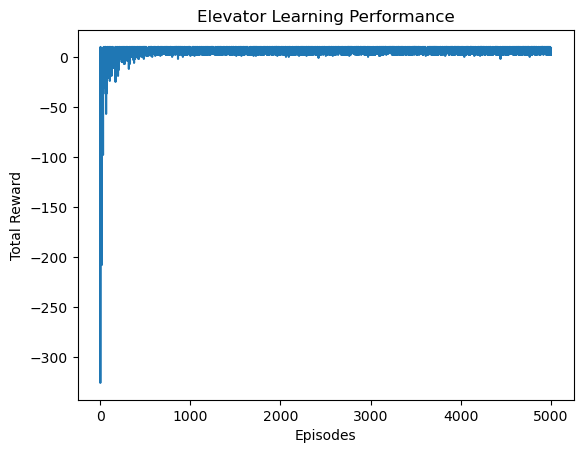

Elevator at Floor: 0, Destination: 0


In [5]:
import numpy as np
import random
import gym  # If using OpenAI Gym for environment
import matplotlib.pyplot as plt

# Create a simple elevator environment
class ElevatorEnv:
    def __init__(self, floors=10):
        self.floors = floors
        self.state = (0, np.random.randint(0, floors))  # (Current floor, Destination)
        self.done = False
    
    def reset(self):
        self.state = (0, np.random.randint(0, self.floors))
        self.done = False
        return self.state
    
    def step(self, action):
        current_floor, destination = self.state
        
        # Action: 0 = Move Down, 1 = Stay, 2 = Move Up
        if action == 0 and current_floor > 0:
            current_floor -= 1
        elif action == 2 and current_floor < self.floors - 1:
            current_floor += 1
        
        # Reward System
        reward = -1  # Default negative reward (penalizing unnecessary moves)
        if current_floor == destination:
            reward = 10  # Big reward for reaching the correct floor
            self.done = True  # Episode ends
        
        self.state = (current_floor, destination)
        return self.state, reward, self.done, {}

    def render(self):
        print(f"Elevator at Floor: {self.state[0]}, Destination: {self.state[1]}")

# Initialize environment
env = ElevatorEnv(floors=10)

# Q-learning hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration probability
epsilon_decay = 0.995  # Decay rate for epsilon
min_epsilon = 0.01  # Minimum epsilon value
num_episodes = 5000  # Number of training episodes

# Initialize Q-table (floors x floors x 3 actions)
q_table = np.zeros((env.floors, env.floors, 3))

# Training loop
reward_per_episode = []
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = np.random.choice([0, 1, 2])  # Explore (random action)
        else:
            action = np.argmax(q_table[state[0], state[1]])  # Exploit best action

        # Perform action
        new_state, reward, done, _ = env.step(action)

        # Update Q-table using Bellman equation
        q_table[state[0], state[1], action] = (1 - alpha) * q_table[state[0], state[1], action] + \
                                              alpha * (reward + gamma * np.max(q_table[new_state[0], new_state[1]]))

        state = new_state  # Move to next state
        total_reward += reward

    reward_per_episode.append(total_reward)

    # Decay epsilon (reduce exploration over time)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

# Plot training performance
plt.plot(reward_per_episode)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Elevator Learning Performance")
plt.show()

# Testing the trained model
state = env.reset()
done = False
while not done:
    action = np.argmax(q_table[state[0], state[1]])  # Select best action
    state, reward, done, _ = env.step(action)
    env.render()


In [7]:
# Print total rewards collected during training
print(f"Total Training Rewards: {sum(reward_per_episode)}")

# Testing the trained model
state = env.reset()
done = False
test_total_rewards = 0  # Track rewards during testing

print("\n--- Testing the Elevator Model ---")
while not done:
    action = np.argmax(q_table[state[0], state[1]])  # Select best action
    state, reward, done, _ = env.step(action)
    test_total_rewards += reward  # Accumulate rewards
    env.render()

# Print total rewards collected during testing
print(f"Total Testing Rewards: {test_total_rewards}")


Total Training Rewards: 28714

--- Testing the Elevator Model ---
Elevator at Floor: 1, Destination: 9
Elevator at Floor: 2, Destination: 9
Elevator at Floor: 3, Destination: 9
Elevator at Floor: 4, Destination: 9
Elevator at Floor: 5, Destination: 9
Elevator at Floor: 6, Destination: 9
Elevator at Floor: 7, Destination: 9
Elevator at Floor: 8, Destination: 9
Elevator at Floor: 9, Destination: 9
Total Testing Rewards: 2


In [8]:
print(q_table)


[[[ 9.93560270e+01  2.14959437e+01  2.49768028e+00]
  [ 6.34659804e+00  4.66625335e+00  1.00000000e+01]
  [ 3.50007360e+00  3.55958986e+00  8.00000000e+00]
  [-1.86434303e-01  7.20641143e-01  6.20000000e+00]
  [-5.66922658e-01  1.22471745e-01  4.58000000e+00]
  [-1.16929104e+00 -1.64057805e+00  3.12200000e+00]
  [-2.34577016e+00 -1.89907345e+00  1.80980000e+00]
  [-2.42322067e+00 -2.81311647e+00  6.28820000e-01]
  [-3.18241203e+00 -3.35491845e+00 -4.34062000e-01]
  [-4.15497473e+00 -4.50064432e+00 -1.39065580e+00]]

 [[ 2.45538628e+01 -1.00000000e-02 -2.71000000e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 3.07409454e+00  3.37203930e+00  1.00000000e+01]
  [ 1.75867297e+00  2.91592021e+00  8.00000000e+00]
  [ 1.73075324e-01  1.67182634e-01  6.20000000e+00]
  [-8.82177619e-01  2.70473675e-02  4.58000000e+00]
  [-2.82516986e+00 -1.69703525e+00  3.12200000e+00]
  [-2.52012294e+00 -2.10673365e+00  1.80980000e+00]
  [-3.10384318e+00 -3.09968425e+00  6.28820000e-01]
  [-3.8994

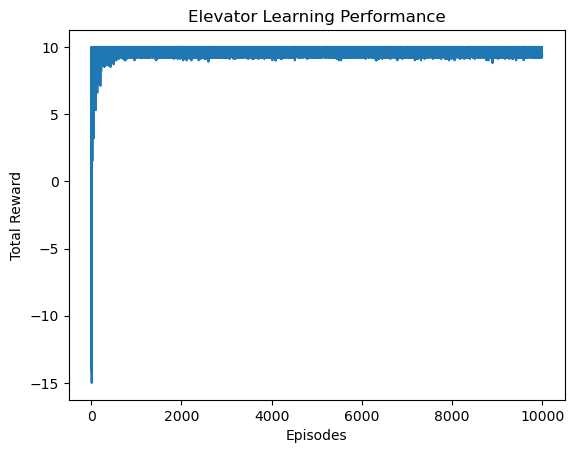

Final Q-Table:
[[[ 3.79529674e+01  9.99932269e+01  1.66241969e+01]
  [ 2.22446331e+00  4.16459231e+00  1.00000000e+01]
  [ 2.78462290e+00  3.24357483e+00  8.90000000e+00]
  [ 3.27373528e+00  1.87260017e+00  7.91000000e+00]
  [ 3.70212452e+00  1.65521017e+00  7.01900000e+00]
  [ 1.80360588e+00  2.16806237e+00  6.21710000e+00]
  [ 1.57947836e+00  2.56740613e+00  5.49539000e+00]
  [ 2.14753144e-01  1.02531875e+00  4.84585100e+00]
  [ 1.02564756e+00  2.63211467e-01  4.26126590e+00]
  [ 6.30827231e-01  2.90784426e-02  3.73513931e+00]]

 [[ 5.39263466e+01  9.77445753e-01  1.46082988e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 4.05893148e+00  4.05200370e+00  1.00000000e+01]
  [ 3.54178842e+00  3.73479013e+00  8.90000000e+00]
  [ 2.28121967e+00  2.51785680e+00  7.91000000e+00]
  [ 8.43822103e-01  9.57051334e-01  7.01900000e+00]
  [ 1.32893138e+00  1.74115936e+00  6.21710000e+00]
  [ 1.92888647e+00 -1.65423493e-01  5.49539000e+00]
  [ 1.18901430e+00  1.35772654e+00  4.84585100e

In [9]:
import numpy as np
import random
import gym  # If using OpenAI Gym for environment
import matplotlib.pyplot as plt

# Create a simple elevator environment
class ElevatorEnv:
    def __init__(self, floors=10):
        self.floors = floors
        self.state = (0, np.random.randint(0, floors))  # (Current floor, Destination)
        self.done = False
    
    def reset(self):
        self.state = (0, np.random.randint(0, self.floors))
        self.done = False
        return self.state
    
    def step(self, action):
        current_floor, destination = self.state
        
        # Action: 0 = Move Down, 1 = Stay, 2 = Move Up
        if action == 0 and current_floor > 0:
            current_floor -= 1
        elif action == 2 and current_floor < self.floors - 1:
            current_floor += 1
        
        # Reward System
        reward = -0.1  # Smaller penalty for unnecessary moves
        if current_floor == destination:
            reward = 10  # Big reward for reaching the correct floor
            self.done = True  # Episode ends
        
        self.state = (current_floor, destination)
        return self.state, reward, self.done, {}

    def render(self):
        print(f"Elevator at Floor: {self.state[0]}, Destination: {self.state[1]}")

# Initialize environment
env = ElevatorEnv(floors=10)

# Q-learning hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration probability
epsilon_decay = 0.995  # Decay rate for epsilon
min_epsilon = 0.01  # Minimum epsilon value
num_episodes = 10000  # Increased training episodes

# Initialize Q-table (floors x floors x 3 actions)
q_table = np.zeros((env.floors, env.floors, 3))

# Training loop
reward_per_episode = []
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = np.random.choice([0, 1, 2])  # Explore (random action)
        else:
            action = np.argmax(q_table[state[0], state[1]])  # Exploit best action

        # Perform action
        new_state, reward, done, _ = env.step(action)

        # Update Q-table using Bellman equation
        q_table[state[0], state[1], action] = (1 - alpha) * q_table[state[0], state[1], action] + \
                                              alpha * (reward + gamma * np.max(q_table[new_state[0], new_state[1]]))

        state = new_state  # Move to next state
        total_reward += reward

    reward_per_episode.append(total_reward)

    # Decay epsilon (reduce exploration over time)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

# Plot training performance
plt.plot(reward_per_episode)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Elevator Learning Performance")
plt.show()

# Debugging: Print Q-table
print("Final Q-Table:")
print(q_table)

# Testing the trained model
epsilon = 0  # Force exploitation during testing
state = env.reset()
done = False
test_reward = 0
while not done:
    action = np.argmax(q_table[state[0], state[1]])  # Select best action
    state, reward, done, _ = env.step(action)
    test_reward += reward
    env.render()

print(f"Total Testing Reward: {test_reward}")
